In [1]:
import pandas as pd 
import numpy as np
from sklearn.tree import DecisionTreeClassifier # Import Decision Tree Classifier
from sklearn.model_selection import train_test_split # Import train_test_split function
from sklearn.metrics import accuracy_score
from sklearn import tree
from sklearn.model_selection import train_test_split
from sklearn import metrics
from sklearn.externals.six import StringIO  
from IPython.display import Image  
from sklearn.tree import export_graphviz
import pydotplus

In [3]:

r = pd.read_excel (r'E:\data set\salesworkload.xlsx')
r.to_csv (r'E:\data set\salesworkload.csv', index = None, header=True)
d=r.drop(['Unnamed: 1', 'Unnamed: 11', 'Unnamed: 12'], axis=1)
d.head(3)

,MonthYear,Country,StoreID,City,Dept_ID,Dept. Name,HoursOwn,HoursLease,Sales units,Turnover,Opening hours
0,10.2016,United Kingdom,88253.0,London (I),1.0,Dry,3184.76,0.0,398560.0,1226244.0,Type A
1,10.2016,United Kingdom,88253.0,London (I),2.0,Frozen,1582.94,0.0,82725.0,387810.0,Type A
2,10.2016,United Kingdom,88253.0,London (I),3.0,other,47.205,0.0,438400.0,654657.0,Type A


In [4]:
d.isna().sum()
d.dropna(inplace=True)

In [5]:
dat=d['class2'] = np.where(d['Turnover']>=3.721393e+06,1 ,0 )
dat=d['class1'] = np.where(d['Turnover']>=3.721393e+06, 'good', 'bad')
dat= d[['Opening hours',  'Turnover','class1','class2']]
dat.head(3)

,Opening hours,Turnover,class1,class2
0,Type A,1226244.0,bad,0
1,Type A,387810.0,bad,0
2,Type A,654657.0,bad,0


In [6]:
data= d[[ 'Turnover','class2']]

In [8]:
import math
def entropy(target_col):
    
    elements,counts = np.unique(target_col,return_counts = True)
    entropy = np.sum([(-counts[i]/np.sum(counts))*np.log2(counts[i]/np.sum(counts)) for i in range(len(elements))])
    return entropy

In [9]:
def InfoGainratio(data,split_attribute_name,target_name="class"):
    
    #Calculate the entropy of the total dataset
    total_entropy = entropy(data[target_name])
    
    #Calculate the values and the corresponding counts for the split attribute 
    vals,counts= np.unique(data[split_attribute_name],return_counts=True)
    
    #Calculate the weighted entropy
    Weighted_Entropy = np.sum([(counts[i]/np.sum(counts))*entropy(data.where(data[split_attribute_name]==vals[i]).dropna()[target_name]) for i in range(len(vals))])
    
    #Calculate the information gain ratio
    Information_Gain = total_entropy - Weighted_Entropy
    
    #threshold_splitinfo = -subset1_probability * math.log(subset1_probability, 2)-subset2_probability*math.log(subset2_probability, 2)
    #gainratio = Information_Gain/ threshold_splitinfo
    
    return Information_Gain

In [10]:
def algo(data,originaldata,features,target_attribute_name="class",parent_node_class = None):
    
    if len(np.unique(data[target_attribute_name])) <= 1:
        return np.unique(data[target_attribute_name])[0]
    
    elif len(data)==0:
        return np.unique(originaldata[target_attribute_name])[np.argmax(np.unique(originaldata[target_attribute_name],return_counts=True)[1])]
    
    elif len(features) ==0:
        return parent_node_class
    
    else:
        
        parent_node_class = np.unique(data[target_attribute_name])[np.argmax(np.unique(data[target_attribute_name],return_counts=True)[1])]
        item_values = [InfoGainratio(data,feature,target_attribute_name) for feature in features] #Return the information gain values for the features in the dataset
        best_feature_index = np.argmax(item_values)
        best_feature = features[best_feature_index]
        
        tree = {best_feature:{}}
        features = [i for i in features if i != best_feature]
        for value in np.unique(data[best_feature]):
            value = value
            sub_data = data.where(data[best_feature] == value).dropna()
            subtree = algo(sub_data,data,features,target_attribute_name,parent_node_class)
            tree[best_feature][value] = subtree
            
        return(tree)    

In [11]:
from pprint import pprint
def algo(data,originaldata,features,target_attribute_name="class2",parent_node_class = None):
    
    if len(np.unique(data[target_attribute_name])) <= 1:
        return np.unique(data[target_attribute_name])[0]
    elif len(data)==0:
        return np.unique(originaldata[target_attribute_name])[np.argmax(np.unique(originaldata[target_attribute_name],return_counts=True)[1])]
    
    
    elif len(features) ==0:
        return parent_node_class
    
    else:
        
        parent_node_class = np.unique(data[target_attribute_name])[np.argmax(np.unique(data[target_attribute_name],return_counts=True)[1])]
        item_values = [InfoGainratio(data,feature,target_attribute_name) for feature in features]
        best_feature_index = np.argmax(item_values)
        best_feature = features[best_feature_index]
        tree = {best_feature:{}}
        features = [i for i in features if i != best_feature]
        
        for value in np.unique(data[best_feature]):
            value = value
            sub_data = data.where(data[best_feature] == value).dropna()
            subtree = algo(sub_data,data,features,target_attribute_name,parent_node_class)
            tree[best_feature][value] = subtree
            
        return(tree)    
                

In [12]:
def predict(query,tree,default = 1):
    
    for key in list(query.keys()):
        if key in list(tree.keys()):
            
            try:
                result = tree[key][query[key]] 
            except:
                return default
  
            result = tree[key][query[key]]
            
            if isinstance(result,dict):
                return predict(query,result)

            else:
                return result

In [13]:
def train_test_split(data):
    training_data = data.iloc[:80].reset_index(drop=True)
    
    testing_data = data.iloc[80:].reset_index(drop=True)
    return training_data,testing_data

training_data = train_test_split(data)[0]
testing_data = train_test_split(data)[1] 


In [39]:
def test(data,tree):
    
    queries = data.iloc[:,:-1].to_dict(orient = "records")
    
    predicted = pd.DataFrame(columns=["predicted"]) 
    
    for i in range(len(data)):
        predicted.loc[i,"predicted"] = predict(queries[i],tree,1.0) 
    print('The prediction accuracy is: ',(np.sum(predicted["predicted"] == data["class2"])/len(data))*100,'%')

In [40]:
tree = algo(training_data,training_data,training_data.columns[:-1])
pprint(tree)
test(testing_data,tree)

{'Turnover': {0.0: 0.0,
              243.0: 0.0,
              3150.0: 0.0,
              140016.0: 0.0,
              170775.0: 0.0,
              251709.0: 0.0,
              264981.0: 0.0,
              272001.0: 0.0,
              290400.0: 0.0,
              311598.0: 0.0,
              313425.0: 0.0,
              329397.0: 0.0,
              364386.0: 0.0,
              369015.0: 0.0,
              382380.0: 0.0,
              387810.0: 0.0,
              444939.0: 0.0,
              450015.0: 0.0,
              451797.0: 0.0,
              453528.0: 0.0,
              499434.0: 0.0,
              511839.0: 0.0,
              523590.0: 0.0,
              573678.0: 0.0,
              583395.0: 0.0,
              654657.0: 0.0,
              825447.0: 0.0,
              842403.0: 0.0,
              859218.0: 0.0,
              1068444.0: 0.0,
              1085793.0: 0.0,
              1155525.0: 0.0,
              1225689.0: 0.0,
              1226244.0: 0.0,
              12918

In [41]:
train_features = data.iloc[:80,:-1]
test_features = data.iloc[80:,:-1]
train_targets = data.iloc[:80,-1]
test_targets = data.iloc[80:,-1]


In [42]:
tree = DecisionTreeClassifier(criterion = 'entropy').fit(train_features,train_targets)

In [43]:
prediction = tree.predict(test_features)


In [44]:
print("The prediction accuracy is: ",tree.score(test_features,test_targets)*100,"%")

The prediction accuracy is:  99.36591809775429 %


In [42]:
d['class3'] = np.where(d['Sales units']>=1.076471e+06,1 ,0 )
d4= d[[ 'Sales units','class3']]
d4.head(3)

,Sales units,class3
0,398560.0,0
1,82725.0,0
2,438400.0,0


In [58]:
from sklearn.tree import DecisionTreeClassifier # Import Decision Tree Classifier
from sklearn.model_selection import train_test_split # Import train_test_split function

from sklearn.metrics import accuracy_score
from sklearn import tree
X = d4.values[:, 1:5]
Y = d4.values[:,0]
X_train, X_test, y_train, y_test = train_test_split( X, Y, test_size = 0.3, random_state = 100)
clf_entropy = DecisionTreeClassifier(criterion = "entropy", random_state = 100,
 max_depth=3, min_samples_leaf=5)            #tree
clf_entropy.fit(X_train, y_train)

DecisionTreeClassifier(class_weight=None, criterion='entropy', max_depth=3,
            max_features=None, max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=5, min_samples_split=2,
            min_weight_fraction_leaf=0.0, presort=False, random_state=100,
            splitter='best')

In [59]:
y_pred_en = clf_entropy.predict(X_test) #information gain 
y_pred_en

array([0., 0., 0., ..., 0., 0., 0.])

In [60]:
print ("Accuracy is ", accuracy_score(y_test,y_pred_en)*100)

Accuracy is  1.7429193899782136


In [61]:
feature_cols = ['Sales units']
X = d4[feature_cols] # Features
y = d4.class3 # Target variable

In [62]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=1)

In [63]:
# Create Decision Tree classifer object
clf = DecisionTreeClassifier()

# Train Decision Tree Classifer
clf = clf.fit(X_train,y_train)

#Predict the response for test dataset
y_pred = clf.predict(X_test)

In [64]:
from sklearn.model_selection import train_test_split
from sklearn import metrics 
clf = DecisionTreeClassifier(criterion="entropy", max_depth=3)

# Train Decision Tree Classifer
clf = clf.fit(X_train,y_train)

#Predict the response for test dataset
y_pred = clf.predict(X_test)

# Model Accuracy, how often is the classifier correct?
print("Accuracy:",metrics.accuracy_score(y_test, y_pred))

Accuracy: 1.0


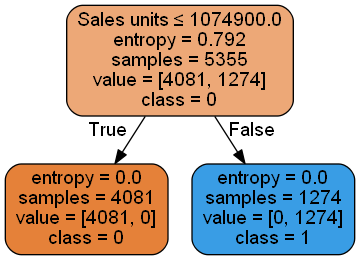

In [65]:
from sklearn.externals.six import StringIO  
from IPython.display import Image  
from sklearn.tree import export_graphviz
import pydotplus
dot_data = StringIO()
export_graphviz(clf, out_file=dot_data,  
                filled=True, rounded=True,
                special_characters=True, feature_names = feature_cols,class_names=['0','1'])
graph = pydotplus.graph_from_dot_data(dot_data.getvalue())  
graph.write_png('turnover.png')
Image(graph.create_png())